# Black–Scholes Option Pricer & Delta Hedging Simulation

In [1]:
import numpy as np
from scipy.stats import norm

# application of Black-Scholes formula
def black_scholes(S, K, r, sigma, T, option="call"):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == "call": # if the option is a call 
        price = S * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        delta = norm.cdf(d1)
    else: # if the option is a put
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
    return price, delta

In [2]:
# Geometric Brownian Motion to generate list of stock prices
def simulate_gbm(S0, r, sigma, T, steps):
    dt = T/steps
    S = np.zeros(steps+1)
    S[0] = S0
    for t in range(1, steps+1):
        z = np.random.normal()
        S[t] = S[t-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return S

In [3]:
# apply the Black-Scholes formula to each stock price and obtain a list of deltas
# compute the total amount of money you have at the end
def delta_hedge_sim(S0, K, r, sigma, T, steps=252):
    S = simulate_gbm(S0, r, sigma, T, steps)
    dt = T/steps
    option_price, delta = black_scholes(S0, K, r, sigma, T)
    cash = option_price - delta * S0 # how much money I have
    deltas = [delta]
    for t in range(1, steps+1):
        tau = T - t*dt
        _, new_delta = black_scholes(S[t], K, r, sigma, tau)
        cash -= (new_delta - delta) * S[t]
        delta = new_delta
        deltas.append(delta)
    payoff = max(S[-1] - K, 0)
    final_value = cash + deltas[-1] * S[-1] - payoff
    return final_value, S, deltas

In [4]:
# Monte-Carlo method : generate multiple outcomes by generating multiple delta-hedging simulations
# creating a list with the amount of money that you have every time
def monte_carlo_hedging(n_paths=5000):
    PnLs = []
    
    for _ in range(n_paths):
        pnl, _, _ = delta_hedge_sim(
            S0=100, K=100, r=0.01, sigma=0.2, T=1, steps=252
        )
        PnLs.append(pnl)
    
    return np.array(PnLs)


/var/folders/cj/xkshcs5n139_nr3cgy1ybq700000gn/T/ipykernel_47628/541059748.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))


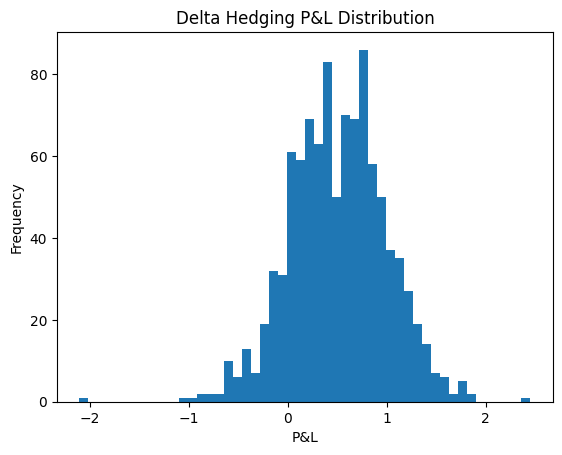

In [5]:
import matplotlib.pyplot as plt

# plot the results of Monte-Carlo simulation to visualise dispersion of P&Ls
PnL = monte_carlo_hedging(1000)
plt.hist(PnL, bins=50)
plt.title("Delta Hedging P&L Distribution")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.show()


In [6]:
# example of Black–Scholes pricing
S0 = 100
K = 100
r = 0.01
sigma = 0.2
T = 1  # duration of 1 year

price, delta = black_scholes(S0, K, r, sigma, T, option="call")
print("Call price:", price)
print("Delta:", delta)


Call price: 8.433318690109608
Delta: 0.5596176923702425


In [7]:
# example of the P&L obtained after delta-hedging
pnl, S, deltas = delta_hedge_sim(S0, K, r, sigma, T, steps=252)
print("Final P&L:", pnl)


Final P&L: 0.44278548920654376


/var/folders/cj/xkshcs5n139_nr3cgy1ybq700000gn/T/ipykernel_47628/541059748.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
